# Architecture experiment: Subjective and physiological responses to interiors


### Libraries

- [scikit-learn](http://scikit-learn.org/stable/)
- pandas
- matplotlib
- seaborn
- keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns 
%matplotlib inline

In [2]:
DATA_FOLDER = './data/' #The data is in the .gitignore in order to not upload it to the GitHub repository
VIS_FOLDER = './visualizations/' #Folder where save the visualizations
MODELS_FOLDER = './sklearn_models/'

Execute the following line to export from the jupyter notebook(.ipynb) to a .py file (ignore the warnings):

In [3]:
#!jupyter nbconvert --to script Project2-Notebook - New Approach.ipynb 

For not showing the warnings:

In [4]:
import warnings
warnings.filterwarnings(action = 'ignore')

## Exploratory Data Analysis

### Loading phase

First we load the data into a Pandas data frame (with the Pandas library; to install this package with conda run:
`conda install -c anaconda pandas`):

In [5]:
df_interior_features = pd.read_csv(DATA_FOLDER + 'T_features.csv')
df_labels_and_features = pd.read_csv(DATA_FOLDER + 'table_dataset_GreeceSwitzerland_N265_metrics_mSC5_JPEGtoBMP_Michelson_RMS.csv')

Let's see what is inside `table_dataset_GreeceSwitzerland_N265_metrics_mSC5_JPEGtoBMP_Michelson_RMS.csv`:

In [6]:
df_labels_and_features.head(7)

,ID,Country,Stimulus_SkyType,Stimulus_Context,Gender,Pattern,pleasant,interesting,exciting,calming,complex,bright,view,spacious,contrast_mean_mSC5,contrast_mean_Michelson,contrast_mean_RMS,complexity_mean_JPEGtoBMP
0,1,Greece,clear low,social,Male,P1EL,8,7,6,9,4,6,4,8,11.188207,0.907864,106.363985,0.104734
1,1,Greece,clear low,social,Male,P2EL,8,5,6,8,4,7,3,8,11.941067,0.904661,106.590842,0.122357
2,1,Greece,clear low,social,Male,P3EL,9,8,8,9,6,7,2,8,12.509719,0.905066,106.604335,0.119979
3,1,Greece,clear low,social,Male,P4EL,7,7,7,7,6,6,1,8,12.846015,0.906583,106.929875,0.115287
4,1,Greece,clear low,social,Male,P5EL,8,10,9,7,8,7,5,8,12.211881,0.907546,105.478575,0.118572
5,1,Greece,clear low,social,Male,P6EL,8,8,8,7,9,7,3,8,12.288385,0.912304,106.582042,0.113396
6,2,Greece,clear low,social,Male,P1EL,6,7,8,6,0,7,6,7,11.188207,0.907864,106.363985,0.104734


In [7]:
df_labels_and_features.shape

(1590, 18)

In [8]:
df_labels_and_features.columns

Index([u'ID', u'Country', u'Stimulus_SkyType', u'Stimulus_Context', u'Gender',
       u'Pattern', u'pleasant', u'interesting', u'exciting', u'calming',
       u'complex', u'bright', u'view', u'spacious', u'contrast_mean_mSC5',
       u'contrast_mean_Michelson', u'contrast_mean_RMS',
       u'complexity_mean_JPEGtoBMP'],
      dtype='object')

The data frame has 1590 rows × 18 columns where we can see the original sample of the experiment (both inputs and outputs (xn,yn)). Each column is explained below:
* 'ID': Identifier of the subject of the experiment (of one person).
* 'Country': Country where the person was living.  2 x countries (Greece –138 participants, Switzerland –127 participants)
* 'Stimulus_SkyType': 3 x sky types (clear sky with high sun angle, clear sky with low sun angle, overcast sky)
* 'Stimulus_Context':  2 x context scenarios (social scenario, work scenario)
* 'Gender': Male or Female
* 'Pattern': 6 x patterns (determine how are the blinds, and so how are the shadows)
* Outputs (yn): 'pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright', 'view', 'spacious'. What the people felt in every scene.
* scene metrics (for describing the interior (the kind of room, light, ...) quantitatively): 'contrast_mean_mSC5', 'contrast_mean_Michelson', 'contrast_mean_RMS', 'complexity_mean_JPEGtoBMP'. Obtained by the scenes images.

Note: The metrics in this data set are applied to the whole virtual reallity image (in every interior).

Now let's see what is inside `T_features.csv`:

In [9]:
df_interior_features.head()

,filename,Pattern,Context,SkyType,mean_pleasant,median_pleasant,mean_interesting,median_interesting,mean_calming,median_calming,...,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP
0,p1_social_clearhigh_sg_largewin_simu,P1EL,social,clearhigh,5.439024,6,4.512195,4,5.731707,6.0,...,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797
1,p1_social_clearlow_sg_largewin_simu,P1EL,social,clearlow,5.571429,6,4.510204,5,5.897959,6.0,...,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709
2,p1_social_overcast_sg_largewin_simu,P1EL,social,overcast,6.093023,6,4.790698,5,6.651163,7.0,...,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091
3,p1_work_clearhigh_sg_largewin_simu,P1EL,work,clearhigh,5.804348,6,5.086957,5,6.152174,6.5,...,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,0.124465
4,p1_work_clearlow_sg_largewin_simu,P1EL,work,clearlow,5.255814,5,4.418605,5,5.837209,6.0,...,116,0.937813,0.887639,0.728223,108.174380,112.987399,126.132718,0.102264,0.139392,0.122615


In [10]:
df_interior_features.shape

(36, 31)

In [11]:
df_interior_features.columns

Index([u'filename', u'Pattern', u'Context', u'SkyType', u'mean_pleasant',
       u'median_pleasant', u'mean_interesting', u'median_interesting',
       u'mean_calming', u'median_calming', u'mean_exciting',
       u'median_exciting', u'mean_complex', u'median_complex', u'mean_bright',
       u'median_bright', u'mean_view', u'median_view', u'mean_spacious',
       u'median_spacious', u'contrast_mean_mSC5', u'contrast_max_mSC5',
       u'contrast_mean_Michelson', u'contrast_mean_Michelson_cube123',
       u'contrast_mean_Michelson_cube3', u'contrast_mean_RMS',
       u'contrast_mean_RMS_cube123', u'contrast_mean_RMS_cube3',
       u'complexity_mean_JPEGtoBMP', u'complexity_cube3_JPEGtoBMP',
       u'complexity_cube123_JPEGtoBMP'],
      dtype='object')

We have obtained a data frame with 36 rows × 31 columns. This time we see the features of each kind of interior (the kind of room, light, ...)  and several metrics for describing quantitatively the interior situation. Each column is explained below:
* 'filename': File where we have the cube map projections associated to every scene. (See in `./Cubemap_Projections/BMP/<filename>` or `./Cubemap_Projections/JPEG/<filename>`). The filenames have the structure "p(pattern_id)_(context)_(SkyType)_sg_largewin_simu".
* 'Pattern': 6 x patterns (determine how are the blinds, and so how are the shadows)
* 'Context': 2 x context scenarios (social scenario, work scenario)
* 'SkyType': 3 x sky types (clear sky with high sun angle, clear sky with low sun angle, overcast sky)
* Means and medians of the outputs (of what people have answer in their respective survey) in every scene: 'mean_pleasant', 'median_pleasant', 'mean_interesting', 'median_interesting', 'mean_calming', 'median_calming', mean_exciting', 'median_exciting', 'mean_complex', 'median_complex', 'mean_bright', 'median_bright', 'mean_view', 'median_view', 'mean_spacious', 'median_spacious',
* Interior metrics (for describing the interior quantitatively): 'contrast_mean_mSC5', 'contrast_max_mSC5', 'contrast_mean_Michelson', 'contrast_mean_Michelson_cube123', 'contrast_mean_Michelson_cube3', 'contrast_mean_RMS', 'contrast_mean_RMS_cube123','contrast_mean_RMS_cube3', 'complexity_mean_JPEGtoBMP', 'complexity_cube3_JPEGtoBMP', 'complexity_cube123_JPEGtoBMP'

Note: The metrics in this data set are applied not just to the whole virtual reallity image (we have already this data in the other data frame), but to the different parts of the whole image. Cube1 refers to what you see on your left (when you are doing the experiment with VR), cube2 refers to the front and cube3 refers to the right. Cube123 refers to the metric applied to the three subimages. For more details see`./Cubemap_Projections/JPEG/<filename>`.

Having done this previous load and brief analysis, we are going to create the data frame we are interested in work with. Firstly we find that our inputs (or features) could be classified in two types and we are taking both of them: 
* 1- Features of the people (country and gender) who have taken part in the experiment.
* 2- Features of the interior: Now we are taking both categorical and metrics data.

Secondly, the labels (outputs) of our new data frame are the data that comes from every survey (which has been done by each person): 'pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright', 'view', 'spacious'. We are asked to study first the 'exciting' and the 'calming' labels but we will split the data frame afterwards.

In [12]:
df_labels_and_features.sample()

,ID,Country,Stimulus_SkyType,Stimulus_Context,Gender,Pattern,pleasant,interesting,exciting,calming,complex,bright,view,spacious,contrast_mean_mSC5,contrast_mean_Michelson,contrast_mean_RMS,complexity_mean_JPEGtoBMP
126,22,Greece,clear low,work,Female,P1EL,4,3,5,8,5,7,8,7,11.038933,0.937813,108.17438,0.102264


In [13]:
#df_labels_and_features[df_labels_and_features['ID']==21] #What is the ID meaning?

In [14]:
df_interior_features.head(1)

,filename,Pattern,Context,SkyType,mean_pleasant,median_pleasant,mean_interesting,median_interesting,mean_calming,median_calming,...,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP
0,p1_social_clearhigh_sg_largewin_simu,P1EL,social,clearhigh,5.439024,6,4.512195,4,5.731707,6.0,...,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797


For doing the join, we check that one of the metrics determine totally the interior (there are not two interiors with the same metric value):

In [15]:
df_interior_features["to_join"]=(1000*df_interior_features["contrast_mean_RMS"]).astype(int) #We cannot do the join on the float
df_labels_and_features["to_join"]=(1000*df_labels_and_features["contrast_mean_RMS"]).astype(int) #so we add another column

df_interior_features.set_index("to_join").index.is_unique

True

In [16]:
df_labels_and_features.columns

Index([u'ID', u'Country', u'Stimulus_SkyType', u'Stimulus_Context', u'Gender',
       u'Pattern', u'pleasant', u'interesting', u'exciting', u'calming',
       u'complex', u'bright', u'view', u'spacious', u'contrast_mean_mSC5',
       u'contrast_mean_Michelson', u'contrast_mean_RMS',
       u'complexity_mean_JPEGtoBMP', u'to_join'],
      dtype='object')

In [17]:
df_ml_raw = df_interior_features.merge(df_labels_and_features, on = "to_join", how = 'inner', suffixes = ("_a",""))
df_ml_raw.head(1)

,filename,Pattern_a,Context,SkyType,mean_pleasant,median_pleasant,mean_interesting,median_interesting,mean_calming,median_calming,...,exciting,calming,complex,bright,view,spacious,contrast_mean_mSC5,contrast_mean_Michelson,contrast_mean_RMS,complexity_mean_JPEGtoBMP
0,p1_social_clearhigh_sg_largewin_simu,P1EL,social,clearhigh,5.439024,6,4.512195,4,5.731707,6.0,...,5,7,0,7,6,9,5.023496,0.881714,104.887032,0.101518


In [18]:
df_ml_raw.columns

Index([u'filename', u'Pattern_a', u'Context', u'SkyType', u'mean_pleasant',
       u'median_pleasant', u'mean_interesting', u'median_interesting',
       u'mean_calming', u'median_calming', u'mean_exciting',
       u'median_exciting', u'mean_complex', u'median_complex', u'mean_bright',
       u'median_bright', u'mean_view', u'median_view', u'mean_spacious',
       u'median_spacious', u'contrast_mean_mSC5_a', u'contrast_max_mSC5',
       u'contrast_mean_Michelson_a', u'contrast_mean_Michelson_cube123',
       u'contrast_mean_Michelson_cube3', u'contrast_mean_RMS_a',
       u'contrast_mean_RMS_cube123', u'contrast_mean_RMS_cube3',
       u'complexity_mean_JPEGtoBMP_a', u'complexity_cube3_JPEGtoBMP',
       u'complexity_cube123_JPEGtoBMP', u'to_join', u'ID', u'Country',
       u'Stimulus_SkyType', u'Stimulus_Context', u'Gender', u'Pattern',
       u'pleasant', u'interesting', u'exciting', u'calming', u'complex',
       u'bright', u'view', u'spacious', u'contrast_mean_mSC5',
       u'contr

# Start of the New approach

After having talked with our project supervisor, Kynthia Chamilothori, we decided to change the approach to new one. 

A designer usually do not know the people who will enter to his interior. So even having the ideal predictor it would not be useful for him. Thus it do not makes sense to try to predict what an specific kind of people (for example with a determinated gender or age) is going to fell when entering into a scene.

In this way, we now are going to try to predict the average feelings of people in general. More precisely (by advice of Martin Jaggi) we will predict what percentage of people would have feelings in an intensive way (over a determinated value in the scale 0-10).

Drop the duplicates columns and order the columns in order to have a data frame with the structure X|Y, where X is the matrix of features (each column is a feature) and Y is the matrix with the labels. 

(In this new approach we are not using gender.)

In [19]:
df_ml = df_ml_raw[['Country', 'Pattern', 'Context', 'SkyType', 'contrast_mean_mSC5', 'contrast_max_mSC5', 
               'contrast_mean_Michelson', 'contrast_mean_Michelson_cube123', 'contrast_mean_Michelson_cube3', 
               'contrast_mean_RMS', 'contrast_mean_RMS_cube123', 'contrast_mean_RMS_cube3', 'complexity_mean_JPEGtoBMP',
               'complexity_cube3_JPEGtoBMP', 'complexity_cube123_JPEGtoBMP', 'pleasant', 'interesting', 'exciting', 'calming', 
               'complex', 'bright', 'view', 'spacious']]

In [20]:
df_ml.head(1)

,Country,Pattern,Context,SkyType,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,...,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP,pleasant,interesting,exciting,calming,complex,bright,view,spacious
0,Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,...,0.158865,0.129797,7,5,5,7,0,7,6,9


We can also check and see that there are no missing values. (all instances are non-null)

In [21]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1590 entries, 0 to 1589
Data columns (total 23 columns):
Country                            1590 non-null object
Pattern                            1590 non-null object
Context                            1590 non-null object
SkyType                            1590 non-null object
contrast_mean_mSC5                 1590 non-null float64
contrast_max_mSC5                  1590 non-null int64
contrast_mean_Michelson            1590 non-null float64
contrast_mean_Michelson_cube123    1590 non-null float64
contrast_mean_Michelson_cube3      1590 non-null float64
contrast_mean_RMS                  1590 non-null float64
contrast_mean_RMS_cube123          1590 non-null float64
contrast_mean_RMS_cube3            1590 non-null float64
complexity_mean_JPEGtoBMP          1590 non-null float64
complexity_cube3_JPEGtoBMP         1590 non-null float64
complexity_cube123_JPEGtoBMP       1590 non-null float64
pleasant                           1590 non-

and see that all ratings are between 0 and 10:

In [22]:
df_ml[['pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright',
       'view', 'spacious']].describe().loc[['min','max']]


,pleasant,interesting,exciting,calming,complex,bright,view,spacious
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


Finally, to work with the new approach we need to compute the percentage of ratings  of every scene that are over a certain value (6, 7 or 8 for example). First we take a new data frame with just the 36 different scenes (72 if we are considering the country):

In [23]:
#x_fdata = df_ml.iloc[:,1:15] # For not considering the country
#x_fdata = df_ml.iloc[:,0:15] # For considering the country

fdata = df_ml.iloc[:,0:15] #fdata -> first data without preprocessing
fdata.drop_duplicates(inplace = True)
fdata.set_index(['Country', 'Pattern', 'Context', 'SkyType'], inplace = True)
fdata

,,,,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP
Country,Pattern,Context,SkyType,,,,,,,,,,,
Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797
Switzerland,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797
Greece,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709
Switzerland,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709
Greece,P1EL,social,overcast,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091
Switzerland,P1EL,social,overcast,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091
Greece,P1EL,work,clearhigh,5.362578,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,0.124465
Switzerland,P1EL,work,clearhigh,5.362578,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,0.124465
Greece,P1EL,work,clearlow,11.038933,116,0.937813,0.887639,0.728223,108.174380,112.987399,126.132718,0.102264,0.139392,0.122615


Now we compute the percentages which we are working in this new approach:

In [24]:
computing_percentages_df = df_ml[['Country', 'Pattern', 'Context', 'SkyType']].copy()

limit = 7 ## Change this variable for working with the percentage of people how felt more than limit-excited
df_ml_over_limit = df_ml[df_ml["exciting"] >= limit]
computing_percentages_df2 = df_ml_over_limit[['Country', 'Pattern', 'Context', 'SkyType']].copy()

In [25]:
computing_percentages_df["Total_people"] = 0
computing_percentages_df = computing_percentages_df.groupby(['Country', 'Pattern', 'Context', 'SkyType']).count()

In [26]:
computing_percentages_df2["Excited_people"] = 0
computing_percentages_df2 = computing_percentages_df2.groupby(['Country', 'Pattern', 'Context', 'SkyType']).count()

In [27]:
computing_percentages_joined = pd.DataFrame.join(computing_percentages_df, computing_percentages_df2).fillna(value=0)

In [28]:
fdata = fdata.join(computing_percentages_joined)

In [29]:
fdata[["Total_people", "Excited_people"]].head(3)

,,,,Total_people,Excited_people
Country,Pattern,Context,SkyType,,
Greece,P1EL,social,clearhigh,21,1.0
Switzerland,P1EL,social,clearhigh,20,0.0
Greece,P1EL,social,clearlow,27,5.0


In [30]:
fdata["Percentage_excited_people"] = fdata["Excited_people"] / fdata["Total_people"]

In [31]:
fdata = fdata.drop(columns = ["Total_people", "Excited_people"])
fdata.reset_index(inplace = True)

In [32]:
fdata.head() #Percentage_excited_people in the last column

,Country,Pattern,Context,SkyType,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP,Percentage_excited_people
0,Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797,0.047619
1,Switzerland,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797,0.000000
2,Greece,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709,0.185185
3,Switzerland,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709,0.090909
4,Greece,P1EL,social,overcast,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091,0.227273


In [33]:
x_fdata = fdata.iloc[:, 0:15]
y_data = fdata["Percentage_excited_people"] #Note that y_data is a pandas Series

### Preprocesing Phase

#### Categorical features

From the dataframe we can see that there are 4 categorical features:
1. __*Country*__  
2. __*Pattern*__ 
3. __*Context*__ 
4. __*SkyType*__ 

We can confirm this by checking the type of data for each feature:

In [34]:
x_fdata.dtypes

Country                             object
Pattern                             object
Context                             object
SkyType                             object
contrast_mean_mSC5                 float64
contrast_max_mSC5                    int64
contrast_mean_Michelson            float64
contrast_mean_Michelson_cube123    float64
contrast_mean_Michelson_cube3      float64
contrast_mean_RMS                  float64
contrast_mean_RMS_cube123          float64
contrast_mean_RMS_cube3            float64
complexity_mean_JPEGtoBMP          float64
complexity_cube3_JPEGtoBMP         float64
complexity_cube123_JPEGtoBMP       float64
dtype: object

As we can see the five features mentionned above are the only categorical features (type object).

Let's inspect these features closely:

In [35]:
categorical_features = ['Country','Pattern','Context','SkyType']
for feat in categorical_features:
    print(feat + ':')
    print(x_fdata[feat].value_counts())

Country:
Greece         36
Switzerland    36
Name: Country, dtype: int64
Pattern:
P5EL    12
P6EL    12
P3EL    12
P4EL    12
P1EL    12
P2EL    12
Name: Pattern, dtype: int64
Context:
social    36
work      36
Name: Context, dtype: int64
SkyType:
clearhigh    24
clearlow     24
overcast     24
Name: SkyType, dtype: int64


In order to perform dummy variable encoding on the categorical features, we can use the pandas method `pd.get_dummies()`. Also since we need k-1 dummy variables to represent k categories, we can drop the first column for each encoding (`drop_first = True`). We'll store this as a new dataframe `dummy_df`.

In [36]:
dummy_df = pd.get_dummies(x_fdata, columns=categorical_features, drop_first=False)
dummy_df.head()

,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,...,Pattern_P2EL,Pattern_P3EL,Pattern_P4EL,Pattern_P5EL,Pattern_P6EL,Context_social,Context_work,SkyType_clearhigh,SkyType_clearlow,SkyType_overcast
0,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,...,0,0,0,0,0,1,0,1,0,0
1,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,...,0,0,0,0,0,1,0,1,0,0
2,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,...,0,0,0,0,0,1,0,0,1,0
3,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,...,0,0,0,0,0,1,0,0,1,0
4,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,...,0,0,0,0,0,1,0,0,0,1


We standardize the features in preparation for the training (output excluded, "exciting" column).

In [37]:
x_without_std = dummy_df.copy() #x_without_std is the final data without standardize (Just in case you want to use it)

for feat in dummy_df.columns.tolist():
    mean = dummy_df[feat].mean()
    std = dummy_df[feat].std()
    dummy_df[feat] = (dummy_df[feat] - mean)/std

In [38]:
x_data = dummy_df #x_data will be the final standardized data

#### Splitting the data

In order to split the data into the two sets (training and test), first we need to rejoin the y_data and the x_data. Then we can use the sample method (`pd.sample()`) which  randomly samples from the dataframe according to a given ratio (0.8 for train in this case). The remaining part of the data will be the test set.

In [39]:
#In order to split the data, we join then again:
data = pd.concat([y_data, x_data], axis=1, sort=False)
data.head(1)

,Percentage_excited_people,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,...,Pattern_P2EL,Pattern_P3EL,Pattern_P4EL,Pattern_P5EL,Pattern_P6EL,Context_social,Context_work,SkyType_clearhigh,SkyType_clearlow,SkyType_overcast
0,0.047619,-0.950306,-0.992096,-1.462638,-1.458138,-1.179713,-0.454993,0.636979,0.703101,-0.1363,...,-0.444097,-0.444097,-0.444097,-0.444097,-0.444097,0.993031,-0.993031,1.404358,-0.702179,-0.702179


In [40]:
train_df = data.sample(frac=0.8,replace=False)
test_df = data.drop(train_df.index.tolist(),axis=0)

In [41]:
train_df.head(3)

,Percentage_excited_people,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,...,Pattern_P2EL,Pattern_P3EL,Pattern_P4EL,Pattern_P5EL,Pattern_P6EL,Context_social,Context_work,SkyType_clearhigh,SkyType_clearlow,SkyType_overcast
21,0.000000,1.190925,0.661397,1.140571,0.929926,-0.082194,1.499006,-0.303289,-0.684012,1.600920,...,2.220485,-0.444097,-0.444097,-0.444097,-0.444097,-0.993031,0.993031,-0.702179,1.404358,-0.702179
65,0.523810,-0.598834,0.881863,-0.928654,-0.639226,1.234481,-1.605834,-0.441089,-0.014349,-0.787991,...,-0.444097,-0.444097,-0.444097,-0.444097,2.220485,0.993031,-0.993031,-0.702179,-0.702179,1.404358
27,0.318182,1.508923,-0.716514,-0.357950,-0.774781,0.412748,0.519357,-1.625685,-1.754226,1.857883,...,-0.444097,2.220485,-0.444097,-0.444097,-0.444097,0.993031,-0.993031,-0.702179,1.404358,-0.702179


In [42]:
test_df.head(3)

,Percentage_excited_people,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,...,Pattern_P2EL,Pattern_P3EL,Pattern_P4EL,Pattern_P5EL,Pattern_P6EL,Context_social,Context_work,SkyType_clearhigh,SkyType_clearlow,SkyType_overcast
4,0.227273,-1.135804,-2.810939,-1.253960,-1.193257,-0.436190,-1.743941,-0.527970,0.011704,-0.977339,...,-0.444097,-0.444097,-0.444097,-0.444097,-0.444097,0.993031,-0.993031,-0.702179,-0.702179,1.404358
6,0.173913,-0.838917,0.881863,0.546094,0.533617,-1.903004,0.772877,1.532070,1.295210,-0.386231,...,-0.444097,-0.444097,-0.444097,-0.444097,-0.444097,-0.993031,0.993031,1.404358,-0.702179,-0.702179
8,0.260870,1.025769,0.881863,1.191152,1.020812,0.227417,1.410156,-0.555571,-0.897602,-0.055774,...,-0.444097,-0.444097,-0.444097,-0.444097,-0.444097,-0.993031,0.993031,-0.702179,1.404358,-0.702179


Quick check of the validity of the split by making sure that the size of the train plus the size of the test equals the size of the dummy:

In [43]:
print(train_df.shape[0] + test_df.shape[0] == dummy_df.shape[0])

True


Hence our standardized features and our labels are ready to go.

In [44]:
x_train = train_df.iloc[:,1:-1]
y_train = train_df.iloc[:,0:1]
x_test = test_df.iloc[:,1:-1]
y_test = test_df.iloc[:, 0:1]
#x_data and y_data are the preprocessed data without splitting. Maybe we can use them considering that we have very few data

In [45]:
print(y_train.head)

<bound method DataFrame.head of     Percentage_excited_people
21                   0.000000
65                   0.523810
27                   0.318182
46                   0.227273
43                   0.260870
1                    0.000000
69                   0.250000
15                   0.227273
61                   0.350000
10                   0.136364
34                   0.272727
42                   0.347826
5                    0.047619
48                   0.428571
19                   0.173913
28                   0.545455
26                   0.370370
58                   0.318182
55                   0.434783
35                   0.095238
0                    0.047619
16                   0.227273
3                    0.090909
17                   0.285714
62                   0.407407
66                   0.260870
37                   0.250000
56                   0.478261
51                   0.454545
63                   0.545455
20                   0.173913
2       

In [46]:
print(x_train.head)

<bound method DataFrame.head of     contrast_mean_mSC5  contrast_max_mSC5  contrast_mean_Michelson  \
21            1.190925           0.661397                 1.140571   
65           -0.598834           0.881863                -0.928654   
27            1.508923          -0.716514                -0.357950   
46           -0.522262          -0.055116                 0.775101   
43           -0.272251           0.771630                 0.714451   
1            -0.950306          -0.992096                -1.462638   
69            1.401778           0.936980                 1.606176   
15            1.322121          -1.102329                -0.377114   
61           -0.258284           0.661397                -1.227167   
10           -0.985375          -0.110233                 0.634895   
34           -0.786269          -0.165349                 0.754248   
42           -0.272251           0.771630                 0.714451   
5            -1.135804          -2.810939                -

### Visualizations 

#### Correlations

In [47]:
x_data.columns

Index([u'contrast_mean_mSC5', u'contrast_max_mSC5', u'contrast_mean_Michelson',
       u'contrast_mean_Michelson_cube123', u'contrast_mean_Michelson_cube3',
       u'contrast_mean_RMS', u'contrast_mean_RMS_cube123',
       u'contrast_mean_RMS_cube3', u'complexity_mean_JPEGtoBMP',
       u'complexity_cube3_JPEGtoBMP', u'complexity_cube123_JPEGtoBMP',
       u'Country_Greece', u'Country_Switzerland', u'Pattern_P1EL',
       u'Pattern_P2EL', u'Pattern_P3EL', u'Pattern_P4EL', u'Pattern_P5EL',
       u'Pattern_P6EL', u'Context_social', u'Context_work',
       u'SkyType_clearhigh', u'SkyType_clearlow', u'SkyType_overcast'],
      dtype='object')

In [48]:
data_corr = pd.concat([y_data, x_data], axis=1, sort=False)
data_corr.corr()["Percentage_excited_people"]

Percentage_excited_people          1.000000
contrast_mean_mSC5                 0.283798
contrast_max_mSC5                  0.277502
contrast_mean_Michelson            0.012671
contrast_mean_Michelson_cube123    0.023316
contrast_mean_Michelson_cube3      0.485342
contrast_mean_RMS                 -0.008764
contrast_mean_RMS_cube123         -0.215576
contrast_mean_RMS_cube3           -0.230176
complexity_mean_JPEGtoBMP          0.221907
complexity_cube3_JPEGtoBMP         0.210864
complexity_cube123_JPEGtoBMP       0.242248
Country_Greece                     0.196754
Country_Switzerland               -0.196754
Pattern_P1EL                      -0.508810
Pattern_P2EL                      -0.353035
Pattern_P3EL                       0.118016
Pattern_P4EL                       0.010554
Pattern_P5EL                       0.331097
Pattern_P6EL                       0.402177
Context_social                     0.135230
Context_work                      -0.135230
SkyType_clearhigh               

The correlations of the features with the `Percentage_excited_people` label are neither great nor very low. 
* The greatest one is with the categorical feature `Pattern_P1EL`, which could mean that this pattern has not been exciting for the people in general. 
* We see also that the `contrast_mean_Michelson_cube3` feature has a substantial correlation coefficient of 0,4853.
* As a curiosity, we see that (as Kynthia warned us) the correlation with the country is negative when the country is Switzerland `Country_Switzerland` and positive when the country is Greece `Country_Greece` (what means that people from Greece have been more excited than people from Switzerland).                  

#### Plots

We visualize the relations between "exciting" (response variable) and the numeric features (with the features which were categorical before the "dummy", these visualizations are useless):

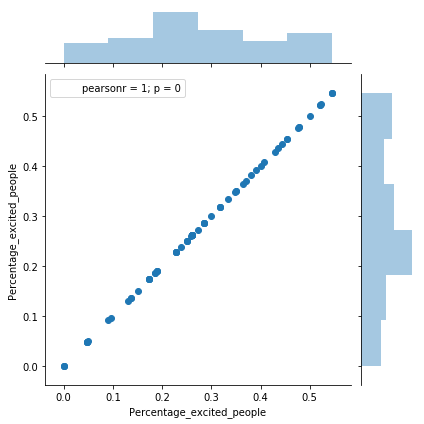

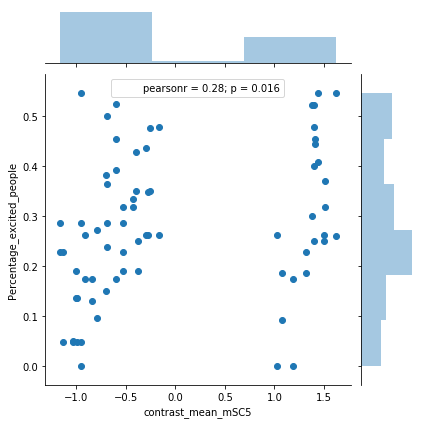

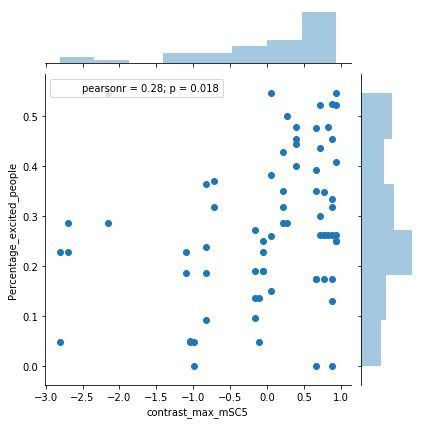

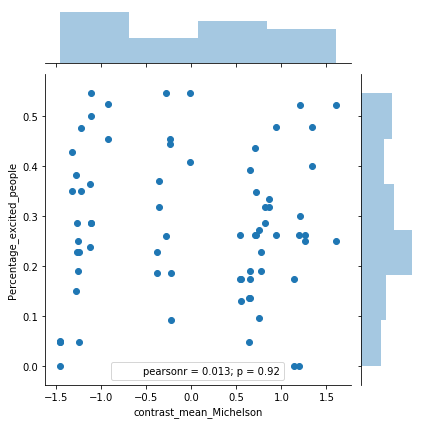

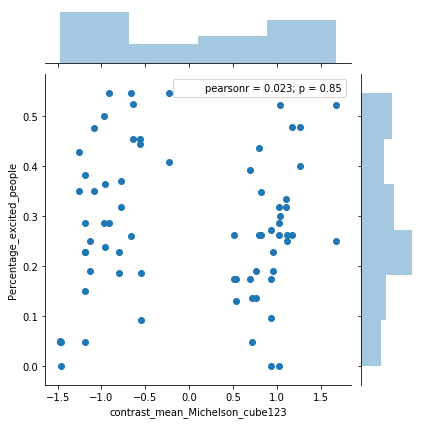

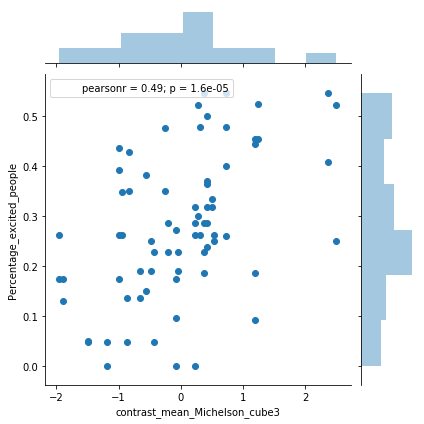

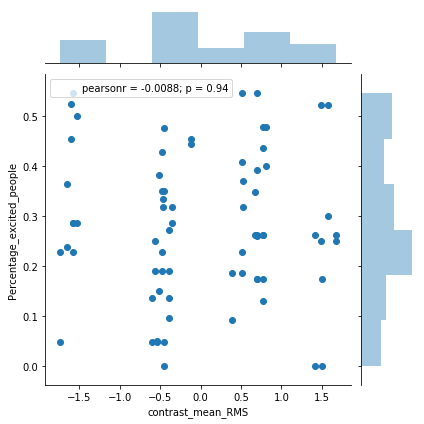

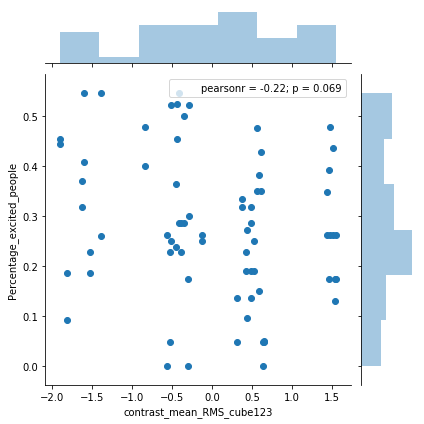

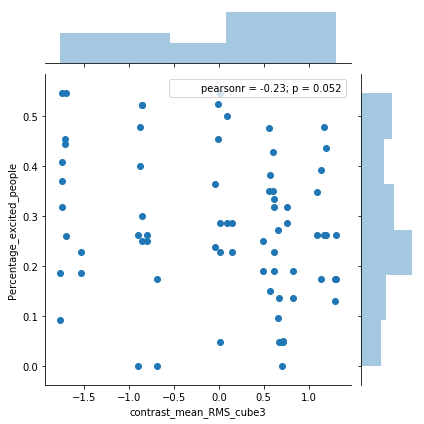

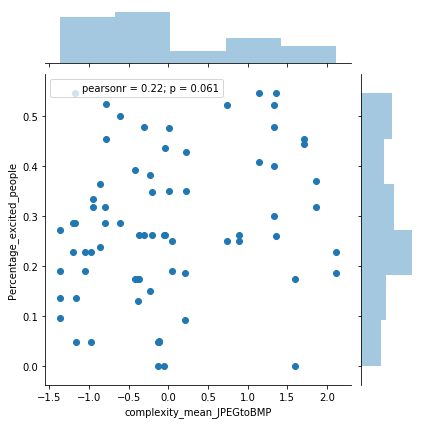

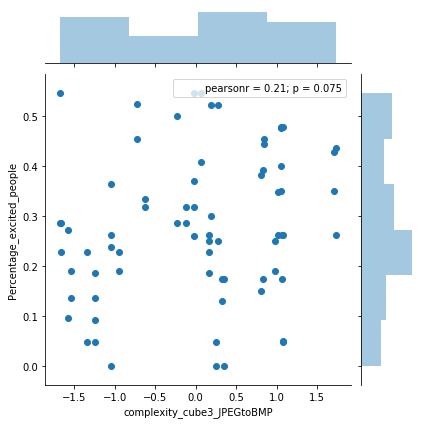

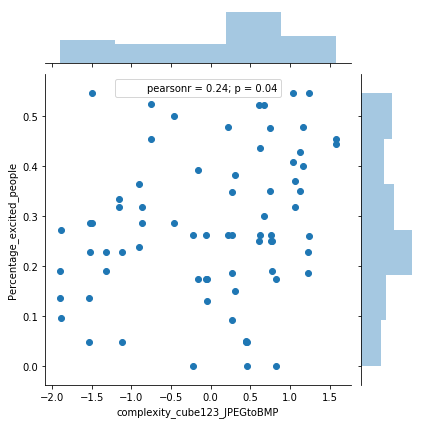

In [49]:
numeric_data = data_corr.drop( [ 'Country_Greece', 'Country_Switzerland', 'Pattern_P1EL', 'Pattern_P2EL',
       'Pattern_P3EL', 'Pattern_P4EL', 'Pattern_P5EL', 'Pattern_P6EL',
       'Context_social', 'Context_work', 'SkyType_clearhigh',
       'SkyType_clearlow', 'SkyType_overcast'], axis = 1)
for feature in numeric_data.columns:
    sns.jointplot( numeric_data[feature], numeric_data['Percentage_excited_people'], kind ="scatter")

We can also demonstrate the linear regression line estimate for each feature.

In [50]:
fig, ax = plt.subplots(round(len(numeric_data.columns) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
        sns.regplot(x=numeric_data.columns[i],y='Percentage_excited_people', data=numeric_data, ax=ax)

TypeError: 'float' object cannot be interpreted as an index

## Exploring different approachs for building the model

Having done that, we can start trying differents methods for obtaining predictions about the excitation/calm of a person who do the experiment.

In [51]:
#!jupyter nbconvert --to script Project2-Notebook - New Approach.ipynb 

In [52]:
#y_train = y_train.transpose()
print(x_train.shape[0], x_train.shape[1])
print(y_train.shape[0], y_train.shape[1])

print(x_test.shape[0], x_test.shape[1])
print(y_test.shape[0], y_test.shape[1])

(58, 23)
(58, 1)
(14, 23)
(14, 1)


### RIDGE REGRESSION 

In [53]:
# First try

In [54]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
clf = Ridge(alpha=1.0)
clf.fit(x_train, y_train)

y_pred=clf.predict(x_train)

In [55]:
#print(y_pred)

In [56]:
#print(y_train) ## I think the results of the model over the trained data seems to be not very bad

In [57]:
import matplotlib.pyplot as plt

In [58]:
# Hard Try

In [59]:
lambdas = np.concatenate((np.array([0]), np.logspace(-9, 10, 22)), axis=0)
degrees = np.array([1, 2, 3, 4, 5])
ypred_train=np.zeros((len(y_train), len(lambdas), len(degrees)))
ypred_test=np.zeros((len(y_test), len(lambdas), len(degrees)))

xtrain=x_train.values
ytrain=y_train.values

xtest=x_test.values
ytest=y_test.values

h=0
w=0
while(w<len(degrees)):
    pol = PolynomialFeatures(degrees[w], True, True)
    phx_train = pol.fit_transform(xtrain, ytrain)
    phx_test = pol.fit_transform(xtest, ytest)
    h=0
    while(h<len(lambdas)):
        clf = Ridge(lambdas[h], solver="lsqr")
        clf.fit(phx_train, y_train)
        ypred_train[:,h,w]=clf.predict(phx_train).transpose()
        ypred_test[:,h,w]=clf.predict(phx_test).transpose()
        h=h+1
    w=w+1

#We can play with the function: PolynomialFeatures

In [60]:
#plt.title("MSE Y pred train vs Lambdas")
#plt.xlabel("Lambdas")
#plt.semilogx(lambdas, mse_pred_test[0])


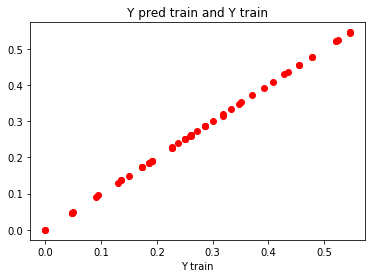

In [61]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_train, ypred_train[:,0,4], 'ro')
#We can see that the shape of the graphic tends to be a linear (everything matches). Seems to OVERFITTING
#Here we are taking degree 5 and small lambda

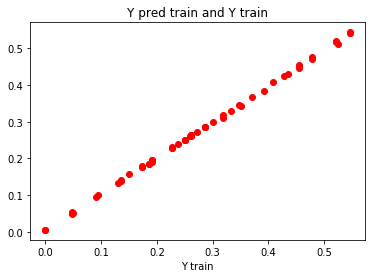

In [62]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_train, ypred_train[:,14,4], 'ro') # Lambda starts to affect (higher values of lambda) 

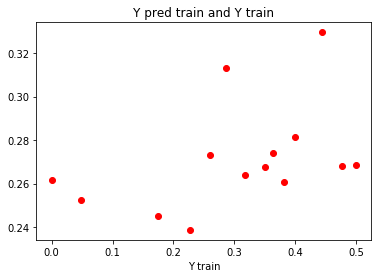

In [63]:
#For the test
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_test, ypred_test[:,16, 4], 'ro')
# As we see we are overfitting, lets plot with less degree

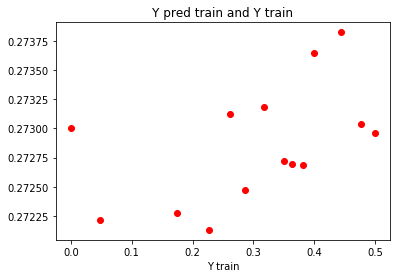

In [64]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_test, ypred_test[:,16, 0], 'ro') #Seems to try to be linear

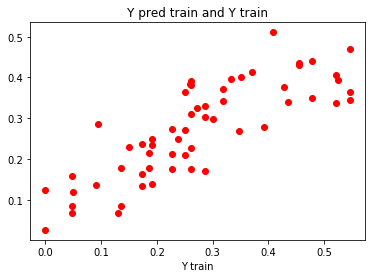

In [65]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_train, ypred_train[:,10, 0], 'ro') #Seems to try to be linear

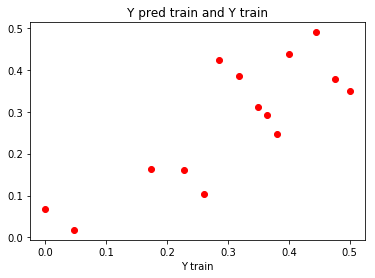

In [66]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_test, ypred_test[:,0, 0], 'ro') #Seems to try to be linear

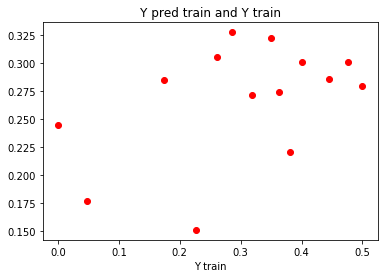

In [67]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_test, ypred_test[:,10, 3], 'ro')

In [68]:
print(ypred_train[:,10])

[[ 1.23142124e-01  4.55521449e-03  3.97513925e-05  2.11591180e-04
   5.31645720e-04]
 [ 3.94851207e-01  5.29926786e-01  5.23752427e-01  5.23462683e-01
   5.23311539e-01]
 [ 3.71945638e-01  3.40552268e-01  3.18232498e-01  3.18621805e-01
   3.19297327e-01]
 [ 2.74690709e-01  2.54718894e-01  2.27314126e-01  2.27029028e-01
   2.27151739e-01]
 [ 2.27619779e-01  3.07348970e-01  2.60983635e-01  2.60616365e-01
   2.61345300e-01]
 [ 2.58867574e-02  2.06942673e-03  2.52098244e-05 -5.70750179e-04
  -3.55276082e-04]
 [ 3.65184490e-01  2.85034627e-01  2.50067826e-01  2.50099784e-01
   2.50478734e-01]
 [ 1.75145278e-01  2.17465281e-01  2.27224360e-01  2.27179410e-01
   2.27014103e-01]
 [ 4.01117033e-01  3.56558613e-01  3.50045270e-01  3.50527241e-01
   3.51618175e-01]
 [ 8.56908254e-02  1.35944726e-01  1.36371281e-01  1.37217006e-01
   1.37337457e-01]
 [ 3.25780310e-01  2.71429150e-01  2.72645267e-01  2.72492454e-01
   2.72326819e-01]
 [ 2.67997610e-01  2.95135329e-01  3.47720086e-01  3.47992970e-01

In [69]:
ypred_train[:,0]

array([[ 1.30770646e-01, -3.97225515e-04, -7.78194695e-04,
        -5.59736482e-04,  5.30402505e-04],
       [ 4.47618377e-01,  5.48909307e-01,  5.24515411e-01,
         5.22988175e-01,  5.23314295e-01],
       [ 3.44809860e-01,  3.37875264e-01,  3.16998973e-01,
         3.18738007e-01,  3.19297212e-01],
       [ 2.42467621e-01,  2.60691080e-01,  2.28419965e-01,
         2.26803930e-01,  2.27150979e-01],
       [ 2.56379649e-01,  3.03266283e-01,  2.62636240e-01,
         2.59923955e-01,  2.61345157e-01],
       [ 2.64322732e-03, -4.89769084e-04,  3.56224268e-04,
        -6.90537863e-04, -3.56740927e-04],
       [ 3.24211021e-01,  2.66263563e-01,  2.51234593e-01,
         2.49766757e-01,  2.50478597e-01],
       [ 1.71764003e-01,  2.26617494e-01,  2.27006705e-01,
         2.28055985e-01,  2.27014019e-01],
       [ 3.42195881e-01,  3.50207127e-01,  3.49317266e-01,
         3.51148007e-01,  3.51619875e-01],
       [ 5.46337290e-02,  1.38152331e-01,  1.36464676e-01,
         1.37602874e-01

In [70]:
ypred_train[:,16]

array([[0.27309409, 0.27208793, 0.25742454, 0.22514219, 0.14715473],
       [0.27311116, 0.27481413, 0.27978726, 0.29825991, 0.3303765 ],
       [0.27342386, 0.27514023, 0.28759197, 0.3011492 , 0.31827868],
       [0.27275145, 0.27189232, 0.26743087, 0.26198129, 0.25726691],
       [0.27262135, 0.27292968, 0.27185818, 0.27028901, 0.26631085],
       [0.27205257, 0.26926975, 0.2456477 , 0.22145205, 0.15076849],
       [0.27396212, 0.27432616, 0.29802387, 0.28856953, 0.27640035],
       [0.27305356, 0.27341562, 0.27343673, 0.26763796, 0.24483239],
       [0.27292059, 0.27214291, 0.27120948, 0.27005671, 0.2776389 ],
       [0.27233105, 0.2725073 , 0.26018702, 0.25885492, 0.2250331 ],
       [0.27273031, 0.27262455, 0.26356761, 0.26471789, 0.25208011],
       [0.27273695, 0.27314275, 0.27433066, 0.27317378, 0.29190164],
       [0.27201506, 0.27043914, 0.24280901, 0.19623993, 0.10749984],
       [0.27283488, 0.2710827 , 0.27275948, 0.28209164, 0.31675232],
       [0.27214541, 0.27242622, 0.

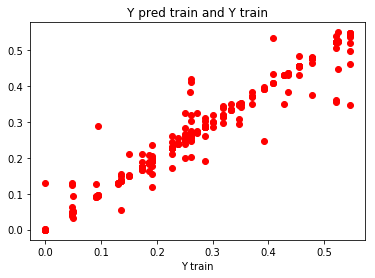

In [71]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_train, ypred_train[:,0], 'ro')

In [72]:
#Grid Search vizualization method
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    #print(scores_mean)
    # Plot Grid search scores
    fig, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    return fig

In [73]:
#NOTE THAT WITH SOME VALUES OF LAMBDA, MAYBE THE 3 DEGREES PLOTS ARE OVERLAPPED (because of the range of the lambda value)

### Ridge regression Using pipelines to make things cleaner

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

estimators = [('poly', PolynomialFeatures()), ('rig_reg', Ridge(solver="lsqr"))]
pipe_ridge = Pipeline(estimators)
pipe_ridge 

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('rig_reg', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='lsqr', tol=0.001))])

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#lambdas = [0.000001,0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
lambdas = np.concatenate((np.array([0]), np.logspace(-9, 4, 22)), axis=0)
degrees = np.array([1, 2, 3, 4])

param_grid = dict(poly__degree = degrees,
                  rig_reg__alpha = lambdas)
grid_search = GridSearchCV(pipe_ridge, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=0)

For rerunning the grid search again, uncomment the following lines (we have used the joblib library in order to save this search and not spend time rerunning it).

In [77]:
import joblib #conda install -c anaconda joblib

In [78]:
#grid_search.fit(X_train, y_train)
#joblib.dump(grid_search, MODELS_FOLDER + 'grid_ridge.pkl')

In [149]:
grid_search = joblib.load(MODELS_FOLDER + 'grid_ridge.pkl')

ValueError: unsupported pickle protocol: 3

In [80]:
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()



Best parameters set found on development set:
()


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [81]:
# Calling Method 
grid_ridge_plot = plot_grid_search(grid_search.cv_results_, lambdas, degrees, 'rig_reg__alpha', 'poly__degree')
grid_ridge_plot.savefig(VIS_FOLDER + 'g_ridge_lambda_degree.png', bbox_inches='tight')

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [82]:
grid_search.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

## Lasso regression

In [160]:
from sklearn.linear_model import Lasso

estimators = [('poly', PolynomialFeatures()), ('lass_reg', Lasso())]
pipe_lasso = Pipeline(estimators) 

#lambdas = [0.000001,0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
lambdas = np.concatenate((np.array([0]), np.logspace(-9, 4, 22)), axis=0)
degrees = np.array([1, 2, 3, 4])

param_grid = dict(poly__degree = degrees,
                  lass_reg__alpha = lambdas)
g_search_lass = GridSearchCV(pipe_lasso, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [151]:
g_search_lass.fit(X_train, y_train)
#joblib.dump(g_search_lass, MODELS_FOLDER + 'grid_lasso.pkl')

KeyboardInterrupt: 

In [152]:
#g_search_lass = joblib.load(MODELS_FOLDER + 'grid_lasso.pkl')

ValueError: unsupported pickle protocol: 3

In [ ]:
# Calling Visualization Method 
grid_lasso_plot = plot_grid_search(g_search_lass.cv_results_, lambdas, degrees, 'lass_reg__alpha', 'poly__degree')
grid_lasso_plot.savefig(VIS_FOLDER + 'g_lasso_lambda_degree.png', bbox_inches='tight')

In [ ]:
print("Best parameters set found on development set:")
print()
print(g_search_lass.best_params_)

In [ ]:
g_search_lass.best_score_

## Random Forest Regression

In [165]:
from sklearn.ensemble import RandomForestRegressor

#estimators = [('poly', PolynomialFeatures()), ('lass_reg', Lasso())]
estimators = [('rf_reg', RandomForestRegressor())]
pipe_rf = Pipeline(estimators)

n_estim = np.arange(1,200,10)
max_depths = np.arange(1,25)

param_grid = dict(rf_reg__n_estimators = n_estim,
                  rf_reg__max_depth = max_depths)
g_search_rf = GridSearchCV(pipe_rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [158]:
g_search_rf.fit(X_train, y_train)
#joblib.dump(g_search_rf, MODELS_FOLDER + 'grid_rf.pkl')

#g_search_rf = joblib.load(MODELS_FOLDER + 'grid_rf.pkl')

KeyboardInterrupt: 

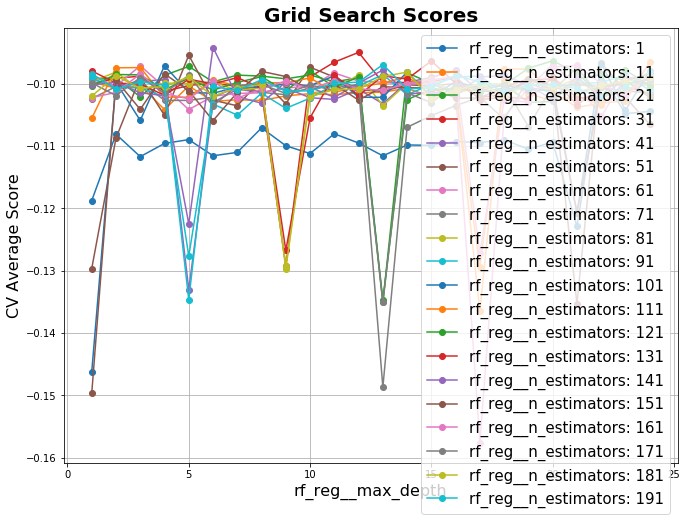

In [230]:
# Calling Visualization Method 
grid_rf_plot = plot_grid_search(g_search_rf.cv_results_, max_depths, n_estim, 'rf_reg__max_depth', 'rf_reg__n_estimators')
grid_rf_plot.savefig(VIS_FOLDER + 'g_rf_depth_estimators.png', bbox_inches='tight')
grid_rf_plot.set_size_inches(11,8)

In [214]:
print("Best parameters set found on development set:")
print()
print(g_search_rf.best_params_)

Best parameters set found on development set:

{'rf_reg__max_depth': 18, 'rf_reg__n_estimators': 11}


In [215]:
g_search_rf.best_score_

-0.09422806427175055

Best parameters before run a grid search with nestim=range(1,100) and max_depths=range(1,100): {'rf_reg__max_depth': 19, 'rf_reg__n_estimators': 10} with score: -0.08968294326799285.

![title](visualizations/grid_search_random_forest_100_100.png)

## XGBOOST regression

In [163]:
import xgboost as xgb

In [164]:
estimators = [('xgb_reg', xgb.XGBRegressor())]
pipe_xgb = Pipeline(estimators)

n_estim = np.arange(1,150, 5)
max_depths = np.arange(1,10)

param_grid = dict(xgb_reg__n_estimators = n_estim,
                  xgb_reg__max_depth = max_depths)
g_search_xgb = GridSearchCV(pipe_xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [234]:
g_search_xgb.fit(X_train, y_train)
joblib.dump(g_search_rf, MODELS_FOLDER + 'grid_xgb.pkl')

#g_search_xgb = joblib.load(MODELS_FOLDER + 'grid_xgb.pkl')

['./sklearn_models/grid_xgb.pkl']

In [235]:
print("Best parameters set found on development set: \n")
print(g_search_xgb.best_params_)
print("\n With the best score:\n")
print(g_search_xgb.best_score_)

Best parameters set found on development set: 

{'xgb_reg__max_depth': 1, 'xgb_reg__n_estimators': 86}

 With the best score:

-0.09732422932538386


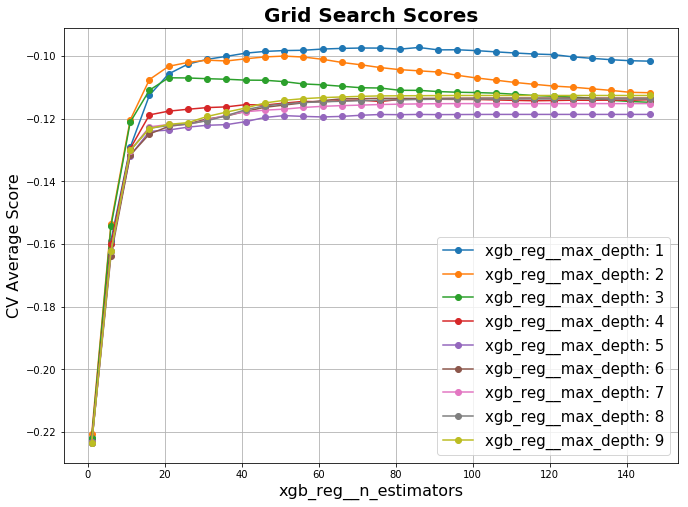

In [237]:
# Calling Visualization Method 
grid_rf_plot = plot_grid_search(g_search_xgb.cv_results_, n_estim, max_depths, 'xgb_reg__n_estimators', 'xgb_reg__max_depth')
grid_rf_plot.savefig(VIS_FOLDER + 'g_xgb_depth_estimators.png', bbox_inches='tight')
grid_rf_plot.set_size_inches(11,8)

# Performing PCA on images

First we read the images and load them into an array.

To install imageio use the command "conda install -c conda-forge imageio"

In [85]:
import imageio

#path= r'C:\Users\kiyarash\Desktop\bmp_images\BMP\p1_social_clearhigh_sg_largewin_simu\cube_persp.bmp'
path = r'C:\Users\jorge\Documents\GitHub\Machine-Learning-Projects\Project2-ArchitectureExperiment\Human Behavior Modelling - Interiors with varying façade characteristics in VR\Cubemap_Projections\BMP\p1_social_clearhigh_sg_largewin_simu\cube_persp.bmp'
im = imageio.imread(path)

print(im.shape)

IOError: No such file: '/Users/Narg/Machine-Learning-Projects/Project2-ArchitectureExperiment/C:\Users\jorge\Documents\GitHub\Machine-Learning-Projects\Project2-ArchitectureExperiment\Human Behavior Modelling - Interiors with varying façade characteristics in VR\Cubemap_Projections\BMP\p1_social_clearhigh_sg_largewin_simu\cube_persp.bmp'

In [86]:
im = np.asarray(im)

NameError: name 'im' is not defined

In [87]:
im.shape

NameError: name 'im' is not defined

In [88]:
plt.imshow(im)

NameError: name 'im' is not defined

In [89]:
#flatten image for use

im = im.flatten()
im.shape

NameError: name 'im' is not defined

In [90]:
# this way we can reproduce the image
im = im.reshape([1368, 4104, 3])
plt.imshow(im)

NameError: name 'im' is not defined

#### Trying to reduce the size of this image as example

See this link: http://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html#sphx-glr-auto-examples-transform-plot-rescale-py

You also need to instal scikit-image: conda install -c anaconda scikit-image 

In [91]:
path2 = r'C:\Users\jorge\Documents\GitHub\Machine-Learning-Projects\Project2-ArchitectureExperiment\Human Behavior Modelling - Interiors with varying façade characteristics in VR\Cubemap_Projections\BMP\p1_social_clearhigh_sg_largewin_simu\cube_persp.bmp'
image = imageio.imread(path2)
image = np.asarray(image)

plt.imshow(image)

IOError: No such file: '/Users/Narg/Machine-Learning-Projects/Project2-ArchitectureExperiment/C:\Users\jorge\Documents\GitHub\Machine-Learning-Projects\Project2-ArchitectureExperiment\Human Behavior Modelling - Interiors with varying façade characteristics in VR\Cubemap_Projections\BMP\p1_social_clearhigh_sg_largewin_simu\cube_persp.bmp'

In [92]:
image.shape

NameError: name 'image' is not defined

THE 3 DIMENSIONS ARE USED FOR THE COLOR, SO IF WE TAKE ONLY ONE OF THEM, I THING WE TAKE THE IMAGE AS GREYSCALE (UNCOMMENT BELOW FOR SEEING):

In [93]:
#plt.imshow(image[:,:,0])

In [94]:
image = image[:,:,0]

NameError: name 'image' is not defined

In [95]:
from skimage.transform import rescale, resize, downscale_local_mean
image_rescaled = rescale(image, 1.0 / 6.0, anti_aliasing=False)  #/4 keep quite image quality 
image_resized = resize(image, (image.shape[0] / 6, image.shape[1] / 6), #/4 keep quite image quality 
                       anti_aliasing=True)
image_downscaled = downscale_local_mean(image, (6,12)) #/(4,3) keep quite image quality 
                                                        #(4,3,1) if we have not removed the 3 dimensions

NameError: name 'image' is not defined

NameError: name 'image' is not defined

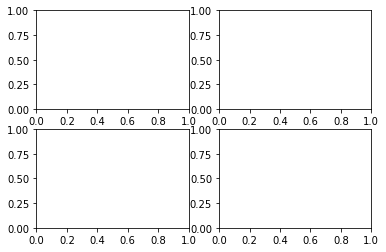

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')#, aspect='auto')   #aspect='auto' for improving the 4 visualizations quality
ax[0].set_title("Original image")

ax[1].imshow(image_rescaled, cmap='gray')#, aspect='auto')
ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized, cmap='gray')#, aspect='auto')
ax[2].set_title("Resized image (no aliasing)")

ax[3].imshow(image_downscaled, cmap='gray')#, aspect='auto')
ax[3].set_title("Downscaled image (no aliasing)")

#ax[0].set_xlim(0, 512)
#ax[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()

#NOTES: Perhaps we should take only the cube 3 image (the front view); since is the one in which you can appreciate the most the blinds and the light. However there are no differences in the furniture.

#It is a bit strange because our image has 3 dimensions; I think it is just because of the colors format.

Which of the image compressions is the best to do? -> They do the same (except for the alisign) but given different arguments.

In [97]:
print(image.shape)
print(image_rescaled.shape)
print(image_resized.shape)
print(image_downscaled.shape)

NameError: name 'image' is not defined

In [98]:
plt.imshow(image_downscaled, cmap='gray', aspect='auto')

NameError: name 'image_downscaled' is not defined

Let's try with the last one process, image_downscaled, but now for every image:

#### Getting the list of pixels of every image:

In [101]:
# read all the images
shadows = ['p1', 'p2', 'p3','p4', 'p5', 'p6']
enviro = ['social', 'work']
sun = ['clearhigh', 'clearlow', 'overcast']

Image_path = "BMP/"
image_name = "cube_persp.bmp"

pixels = []

for sh in shadows:
    for e in enviro:
        for s in sun:
            folder_name = sh+ "_"+ e+ "_"+ s+ "_"+ "sg_largewin_simu/"
            path = Image_path+ folder_name + image_name 
            im = imageio.imread(path)
            #NEW
            im = im[:,:,0]
            im = downscale_local_mean(im, (6,12))
            
            im = np.asarray(im)
            im = im.flatten()
            pixels.append([sh.upper()+"EL", e, s, im])
            

In [102]:
pixels_df = pd.DataFrame(pixels)

In [103]:
pixels_df.columns = ['Pattern', 'Context', 'SkyType', 'img_array']

In [104]:
pixels_df.sample(4)

,Pattern,Context,SkyType,img_array
24,P5EL,social,clearhigh,"[104.0, 104.80555555555554, 105.0, 105.0, 105...."
20,P4EL,social,overcast,"[94.0, 94.41666666666667, 95.0, 95.0, 95.0, 95..."
14,P3EL,social,overcast,"[95.0, 95.34722222222221, 95.9861111111111, 96..."
23,P4EL,work,overcast,"[97.45833333333333, 98.0, 98.0, 98.05555555555..."


In [105]:
fdata[['Country', 'Pattern', 'Context', 'SkyType', 'Percentage_excited_people']].sample(3)

,Country,Pattern,Context,SkyType,Percentage_excited_people
31,Switzerland,P3EL,work,clearhigh,0.173913
48,Greece,P5EL,social,clearhigh,0.428571
22,Greece,P2EL,work,overcast,0.136364


In [106]:
percent_excited = fdata[['Country', 'Pattern', 'Context', 'SkyType', 'Percentage_excited_people']]

In [107]:
pixels_excited_df = percent_excited.set_index(['Pattern', 'Context', 'SkyType']).join(pixels_df.set_index(['Pattern', 'Context', 'SkyType']))

In [108]:
pixels_excited_df

Country  Percentage_excited_people  \
Pattern Context SkyType                                             
P1EL    social  clearhigh       Greece                   0.047619   
                clearhigh  Switzerland                   0.000000   
                clearlow        Greece                   0.185185   
                clearlow   Switzerland                   0.090909   
                overcast        Greece                   0.227273   
                overcast   Switzerland                   0.047619   
        work    clearhigh       Greece                   0.173913   
                clearhigh  Switzerland                   0.130435   
                clearlow        Greece                   0.260870   
                clearlow   Switzerland                   0.000000   
                overcast        Greece                   0.136364   
                overcast   Switzerland                   0.047619   
P2EL    social  clearhigh       Greece                   0.047619   
                clearhigh  Switzerland                   0.050000   
                clearlow        Greece                   0.185185   
                clearlow   Switzerland                   0.227273   
                overcast        Greece                   0.227273   
                overcast   Switzerland                   0.285714   
        work    clearhigh       Greece                   0.260870   
                clearhigh  Switzerland                   0.173913   
                clearlow        Greece                   0.173913   
                clearlow   Switzerland                   0.000000   
                overcast        Greece                   0.136364   
                overcast   Switzerland                   0.190476   
P3EL    social  clearhigh       Greece                   0.380952   
                clearhigh  Switzerland                   0.150000   
                clearlow        Greece                   0.370370   
                clearlow   Switzerland                   0.318182   
                overcast        Greece                   0.545455   
                overcast   Switzerland                   0.285714   
...                                ...                        ...   
P4EL    work    clearhigh       Greece                   0.347826   
                clearhigh  Switzerland                   0.260870   
                clearlow        Greece                   0.260870   
                clearlow   Switzerland                   0.250000   
                overcast        Greece                   0.227273   
                overcast   Switzerland                   0.190476   
P5EL    social  clearhigh       Greece                   0.428571   
                clearhigh  Switzerland                   0.350000   
                clearlow        Greece                   0.444444   
                clearlow   Switzerland                   0.454545   
                overcast        Greece                   0.500000   
                overcast   Switzerland                   0.285714   
        work    clearhigh       Greece                   0.260870   
                clearhigh  Switzerland                   0.434783   
                clearlow        Greece                   0.478261   
                clearlow   Switzerland                   0.400000   
                overcast        Greece                   0.318182   
                overcast   Switzerland                   0.285714   
P6EL    social  clearhigh       Greece                   0.476190   
                clearhigh  Switzerland                   0.350000   
                clearlow        Greece                   0.407407   
                clearlow   Switzerland                   0.545455   
                overcast        Greece                   0.454545   
                overcast   Switzerland                   0.523810   
        work    clearhigh       Greece                   0.260870   
                clearhigh  Sw

# Trying to use the PCA as in this example: 

https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py

The PCA does an unsupervised dimensionality reduction, while the ridge regression does the prediction.
We use a GridSearchCV to set the dimensionality of the PCA.

In [109]:
from sklearn.decomposition import PCA
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('rig_reg', Ridge(solver="lsqr"))]) 

#Recall: ||y - Xw||^2_2 + alpha * ||w||^2_2
# Ridge regression solves a regression model where the loss function is the linear least squares function 
#and regularization is given by the l2-norm.

In [110]:
"""
# This is what the web page example do (I put it just for helping you to understand what I have done (check if it is good!))
from sklearn import datasets
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target
"""

'\n# This is what the web page example do (I put it just for helping you to understand what I have done (check if it is good!))\nfrom sklearn import datasets\ndigits = datasets.load_digits()\nX_digits = digits.data\ny_digits = digits.target\n'

In [111]:
pixels_greece = pixels_excited_df[pixels_excited_df["Country"]=="Greece"]
pixels_switz = pixels_excited_df[pixels_excited_df["Country"]=="Switzerland"]

In [112]:
x_matrix_temp_greece = [pixels_array.tolist() for pixels_array in pixels_greece["img_array"].values]
x_matrix_temp_switz = [pixels_array.tolist() for pixels_array in pixels_switz["img_array"].values]
x_matrix_temp_greece

[[103.0,
  103.125,
  103.84722222222221,
  103.95833333333333,
  104.68055555555556,
  105.0,
  105.0,
  105.0,
  105.0,
  105.0,
  105.75000000000001,
  106.33333333333333,
  106.16666666666669,
  106.125,
  106.0,
  106.0,
  106.22222222222223,
  106.98611111111113,
  106.9861111111111,
  106.43055555555556,
  106.0,
  105.56944444444444,
  105.77777777777777,
  105.18055555555556,
  104.9861111111111,
  104.38888888888887,
  103.08333333333333,
  101.375,
  98.98611111111113,
  95.58333333333333,
  90.80555555555554,
  82.06944444444444,
  54.09722222222222,
  39.52777777777778,
  45.97222222222223,
  51.09722222222222,
  55.13888888888889,
  57.97222222222222,
  59.958333333333336,
  117.59722222222223,
  154.23611111111111,
  154.05555555555557,
  153.22222222222223,
  152.26388888888889,
  152.63888888888889,
  153.875,
  166.2777777777778,
  179.72222222222226,
  177.98611111111111,
  176.88888888888889,
  175.25,
  173.98611111111111,
  172.9861111111111,
  173.15277777777774,

In [113]:
print(len(x_matrix_temp_greece))
print(len(x_matrix_temp_greece[0]))

36
77976


In [114]:
aaaaa #Next instruction is long to execute (this is just for stop the execution if you usually rerun the whole notebook)

NameError: name 'aaaaa' is not defined

## FINDING THE BEST MODEL

### PREPARING MATRICES

In [ ]:
from sklearn import preprocessing

In [219]:
### Preparing Matrices

## Greece
X_digits_greece = x_matrix_temp_greece
y_digits_greece = pixels_greece["Percentage_excited_people"].values

# Standardize
X_greece = preprocessing.scale(X_digits_greece)

# Splitting of the data
phX_train_greece, phX_test_greece, y_train_greece, y_test_greece = train_test_split(X_greece, y_digits_greece, test_size=0.2, random_state=0)

# Pol expansion (in our case add a constant (bias)) for all data
pol = PolynomialFeatures(1, True, True)
phX_train_reece = pol.fit_transform(phX_train_greece, y_train_greece)
phX_test_reece = pol.fit_transform(phX_test_greece, y_test_greece)


## Switzerland
X_digits_switz = x_matrix_temp_switz
y_digits_switz = pixels_switz["Percentage_excited_people"].values

# Standardize
X_switz = preprocessing.scale(X_digits_switz)

# Splitting of the data
phX_train_switz, phX_test_switz, y_train_switz, y_test_switz = train_test_split(X_switz, y_digits_switz, test_size=0.2, random_state=0)

# Pol expansion (in our case add a constant (bias)) for all data
pol = PolynomialFeatures(1, True, True)
phX_train_reece = pol.fit_transform(phX_train_switz, y_train_switz)
phX_test_reece = pol.fit_transform(phX_test_switz, y_test_switz)

### REGRESSION GRID SEARCH: SELECTING THE BEST MODEL

In [217]:
pca = PCA()

### Preparing the pipes
pipes = []
estimators_ridge = steps = [('pca', pca), ('rig_reg', Ridge(solver="lsqr"))]
pipe_ridge = Pipeline(estimators_ridge)

estimators_lasso = steps = [('pca', pca), ('lass_reg', Lasso())]
pipe_lasso = Pipeline(estimators_lasso) 

estimators_rf = steps = [('pca', pca), ('rf_reg', RandomForestRegressor())]
pipe_rf = Pipeline(estimators_rf)

estimators = steps = [('pca', pca), ('xgb_reg', xgb.XGBRegressor())]
pipe_xgb = Pipeline(estimators)

pipes = [pipe_ridge, pipe_lasso, pipe_rf, pipe_xgb]
## Preparing the Grid Search with cross-validation; so it is splitting and we cannot put more than len(phX_train_greece) components
param_grid = []

## Parameters of pipelines can be set using ‘__’ separated parameter names:

PCA_n_comp = np.arange(1, 22, 2) # must be between 0 and min(n_samples, n_features)=n_samples=phX_train_greece

# Ridge
lambdas = np.logspace(3, 5, 15)

param_grid_ridge = dict(pca__n_components = PCA_n_comp, rig_reg__alpha = lambdas)

# Lasso
lambdas = np.logspace(2, 5, 15)
#lambdas = np.concatenate((np.array([0]), np.logspace(-9, 4, 22)), axis=0)

param_grid_lasso = dict(pca__n_components = PCA_n_comp, lass_reg__alpha = lambdas)

# XGB
n_estim = np.arange(10,150, 10)
max_depths = np.arange(1,25, 5)

param_grid_xgb = dict(xgb_reg__n_estimators = n_estim, xgb_reg__max_depth = max_depths, pca__n_components = PCA_n_comp)

# RF
n_estim = np.arange(10,200, 10)
max_depths = np.arange(1,25, 5)

param_grid_rf = dict(rf_reg__n_estimators = n_estim, rf_reg__max_depth = max_depths, pca__n_components = PCA_n_comp)

## Param grid for every model

param_grid = [param_grid_ridge, param_grid_lasso, param_grid_rf, param_grid_xgb]

#### GREECE

In [ ]:
search_greece = []
#Running GRID SEARCH WITH ALL THE ESTIMATORS
h=0
while(h<len(pipes)):
    ## Instantiation of Grid Search
    #Grid search will take by default the estimator's default scorer, i.e. the least squares from ridge regression estimator

    search_greece.append(GridSearchCV(pipes[h], param_grid[h], iid=False, cv=5, return_train_score=True, scoring = 'neg_mean_absolute_error')) #We can change it to false if we are not interested in this score
    #Note: iid-> the loss minimized is the total loss per sample, and not the mean loss across the folds! Put it a false if we use
    
    ## Modeling
    search_greece[h].fit(phX_train_greece, y_train_greece)
    
    h=h+1

In [216]:
joblib.dump(search_greece, MODELS_FOLDER + 'final_grid_greece.pkl')
#search_greece = joblib.load(MODELS_FOLDER + 'final_grid_greece.pkl')

In [208]:
### Getting best result for every model-estimator
ypred_test_greece = np.zeros((len(search_greece), len(y_test_greece)))
dif_rest_greece = np.zeros(len(search_greece))
mse_rest_greece = np.zeros(len(search_greece))

h=0
while(h<len(search_greece)):
    ypred_test_greece[h] = search_greece[h].predict(phX_test_greece)
    dif_rest_greece[h] = sum(abs(ypred_test_greece[h]-y_test_greece))/len(y_test_greece)
    mse_rest_greece[h] = sum(abs(ypred_test_greece-y_test_greece)**2)/len(y_test_greece))
    
    
    ### Running GRID SEARCH

    print("Best parameter (CV score=%0.3f):" % search_greece[h].best_score_)
    print(search_greece[h].best_params_)
    print(dif_rest_greece[h])
    print(mse_rest_greece[h])
    
    h=h+1

0.12009944515901955
0.11369508826806961
0.13293252055983362
0.1314720176813198


#### SWITZERLAND

In [ ]:
search_switz = []
#Running GRID SEARCH WITH ALL THE ESTIMATORS
h=0
while(h<len(pipes)):
    ## Instantiation of Grid Search
    #Grid search will take by default the estimator's default scorer, i.e. the least squares from ridge regression estimator

    search_switz.append(GridSearchCV(pipes[h], param_grid[h], iid=False, cv=5, return_train_score=True, scoring = 'neg_mean_absolute_error')) #We can change it to false if we are not interested in this score
    #Note: iid-> the loss minimized is the total loss per sample, and not the mean loss across the folds! Put it a false if we use
    
    ## Modeling
    search_switz[h].fit(phX_train_switz, y_train_switz)
    
    h=h+1

In [ ]:
joblib.dump(search_switz, MODELS_FOLDER + 'final_grid_switz.pkl')
#search_switz = joblib.load(MODELS_FOLDER + 'final_grid_switz.pkl')

In [ ]:
### Getting best result for every model-estimator
ypred_test_switz = np.zeros((len(search_switz), len(y_test_switz)))
dif_rest_switz = np.zeros(len(search_switz))
mse_rest_switz = np.zeros(len(search_switz))

h=0
while(h<len(search_switz)):
    ypred_test_switz[h] = search_greece[h].predict(phX_test_switz)
    dif_rest_switz[h] = sum(abs(ypred_test_switz[h]-y_test_switz))/len(y_test_switz)
    mse_rest_switz[h] = sum(abs(ypred_test_switz-y_test_switz)**2)/len(y_test_switz))
    
    
    ### Running GRID SEARCH

    print("Best parameter (CV score=%0.3f):" % search_switz[h].best_score_)
    print(search_switz[h].best_params_)
    print(dif_rest_switz[h])
    print(mse_rest_switz[h])
    
    h=h+1

In [212]:
### Manually predicting base in the Grid Search results
#Building the model with the best parameters
clf = Ridge(13894.95494373136, solver="lsqr")
clf.fit(phX_train_greece, y_train_greece)
ypred_train_greece=clf.predict(phX_train_greece).transpose()
ypred_test_greece=clf.predict(phX_test_greece).transpose()

print(sum(abs(ypred_test_greece-y_test_greece))/len(y_test_greece))
print(sum(abs(ypred_test_greece-y_test_greece)**2)/len(y_test_greece))

#print(sum(abs(ypred_train_greece-y_train_greece)))/len(y_train_greece)
print(clf.coef_)

0.06863255846578317
0.007407443200178092
[ 1.60373727e-06  1.32481211e-06  8.78390536e-07 ... -4.55845487e-06
 -5.22676645e-06 -5.27771914e-06]


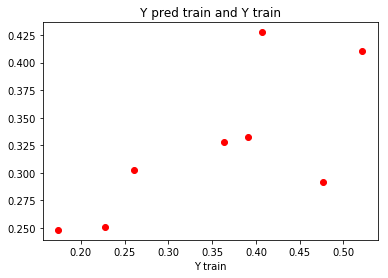

In [213]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_test_greece, ypred_test_greece, 'ro')
#plt.plot(y_train_greece, ypred_train_greece, 'ro')

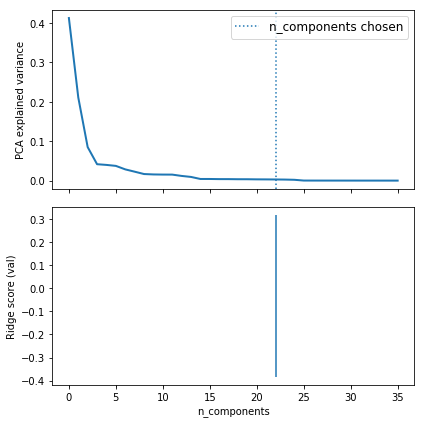

In [138]:
# Plot the PCA spectrum
pca.fit(X_greece)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Ridge score (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()

In [139]:
grid_ridge_plot = plot_grid_search(search.cv_results_, lambdas, pca_ncomp, 'rig_reg__alpha', 'pca__n_components')
grid_ridge_plot.savefig(VIS_FOLDER + 'g_PCA_ridge.png', bbox_inches='tight')

NameError: name 'pca_ncomp' is not defined

In [140]:
search

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rig_reg', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='lsqr', tol=0.001))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'pca__n_components': [22], 'rig_reg__alpha': array([ 10000.     ,  10046.25062, ...,  99539.6231 , 100000.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [141]:
type(grid_search)

sklearn.model_selection._search.GridSearchCV

In [ ]:
type(search)

In [ ]:
#path = 'BMP/p1_social_clearhigh_sg_largewin_simu/cube_persp.bmp'

